In [2]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [3]:
lasso = h5py.File('monkey1.h5', 'r')
poisson = h5py.File('pvc11_poisson.h5', 'r')
glmnet = h5py.File('glmnet.h5', 'r')

In [6]:
list(lasso)

['Y']

In [5]:
poisson_coefs = np.median(poisson['monkey1/log/coupling_coefs'][:], axis=0)
lasso_coefs = np.median(lasso['UoI_Lasso_R2/coupling_coefs'][:], axis=0)
glmnet_coefs = np.median(glmnet['coupling_coefs'], axis=0)

KeyError: 'Unable to open object (component not found)'

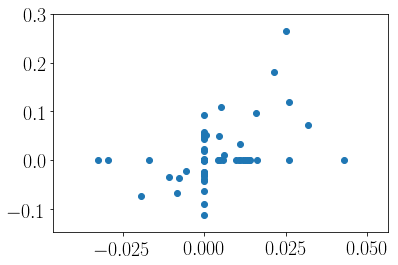

In [114]:
plt.scatter(poisson_coefs[3], lasso_coefs[3])

In [116]:
corrs = np.zeros(106)
for neuron in range(106):
    corrs[neuron] = np.corrcoef(poisson_coefs[neuron], lasso_coefs[neuron])[0, 1]

(0, 1)

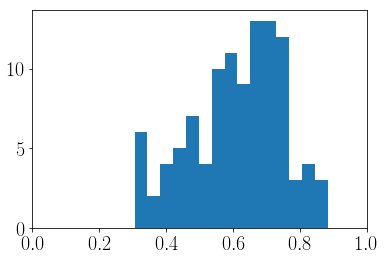

In [120]:
plt.hist(corrs, bins=15)
plt.xlim([0, 1])

In [49]:
lasso_coefs[0]

array([ 0.07007192,  0.        ,  0.        , -0.09806447,  0.        ,
        0.06432198,  0.        ,  0.05408509,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.00485619, -0.07595847,  0.        ,  0.02135659,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.05674101,
        0.        , -0.08773577,  0.        ,  0.        ,  0.07481973,
        0.        ,  0.        ,  0.05245953,  0.04058525,  0.        ,
        0.052254  ,  0.        ,  0.        ,  0.03912664,  0.02029496,
        0.        ,  0.        ,  0.        ,  0.04393795,  0.0317671 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.10587043, -0.06485046,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.04106441,  0.  

In [93]:
np.count_nonzero(poisson_coefs[31] != 0 )

27

In [94]:
ruff = np.zeros(105)
ruff[:27] = 1
sel_profile = (poisson_coefs[31] != 0).astype('int')
reps = 1000000
n_correct = np.zeros(reps)
for rep in range(reps):
    np.random.shuffle(ruff)
    n_correct[rep] = np.count_nonzero(ruff * sel_profile) / np.count_nonzero(sel_profile)

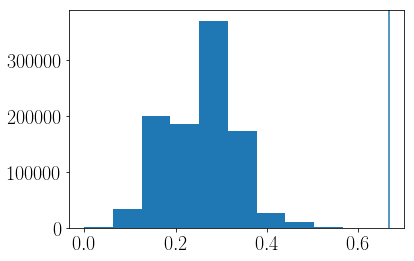

In [104]:
plt.hist(n_correct)
plt.axvline(np.count_nonzero(poisson_coefs[31] * lasso_coefs[31]) / np.count_nonzero(sel_profile))

In [95]:
np.mean(n_correct)

0.2571333703703704

In [97]:
27/105

0.2571428571428571

In [102]:
27**2/105**2

0.06612244897959184

In [103]:
np.std(n_correct)

0.07277705545583495

In [92]:
for neuron in range(106):
    ruff1 = (np.count_nonzero(poisson_coefs[neuron] * lasso_coefs[neuron])/np.count_nonzero(poisson_coefs[neuron]))
    ruff2 = np.count_nonzero(poisson_coefs[neuron])/105.
    
    print(ruff1/ruff2)

2.2176308539944904
1.554
1.748178980228928
1.4462809917355373
1.6447134211463155
1.9703703703703705
1.7474112426035504
1.6240333135038667
1.5426997245179064
1.5879017013232515
2.216666666666667
2.0238095238095237
6.9421487603305785
1.3884297520661157
2.9166666666666665
1.7857142857142856
2.4609375
1.3058035714285714
1.50390625
2.025462962962963
1.9174579985390794
1.9047619047619047
2.5068870523415976
1.3321799307958477
1.518595041322314
1.907439446366782
1.4367603550295858
1.5555555555555556
1.8727705112960762
2.5520833333333335
2.5068870523415976
2.5925925925925926
1.7257785467128026
3.1994459833795017
1.8062471706654593
1.5325738697045213
1.2358533272974197
1.3498622589531681
3.9375
1.5339663988312637
1.378125
1.5877712031558184
1.2037721893491125
1.2833861475780897
1.09375
1.3671875
1.681301652892562
1.4886578449905483
1.5699537201851195
1.8457031249999998
1.7948717948717947
4.212962962962963
1.5476190476190477
2.089100346020761
1.24054820415879
1.1340000000000001
1.5270083102493077

In [69]:
(poisson_coefs[30] != 0).astype('int')

array([1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0])